In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, GlobalAveragePooling1D

import yfinance as yf

In [ ]:
def calculate_bollinger_bands(data, window=10, num_of_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_of_std)
    lower_band = rolling_mean - (rolling_std * num_of_std)
    return upper_band, lower_band

def calculate_rsi(data, window=10):
    """Calculate Relative Strength Index"""
    delta = data.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_roc(data, periods=10):
    """Calculate Rate of Change."""
    roc = ((data - data.shift(periods)) / data.shift(periods)) * 100
    return roc

In [ ]:
tickers = ['META', 'AAPL', 'MSFT', 'AMZN', 'GOOG']

[*********************100%***********************]  1 of 1 completed


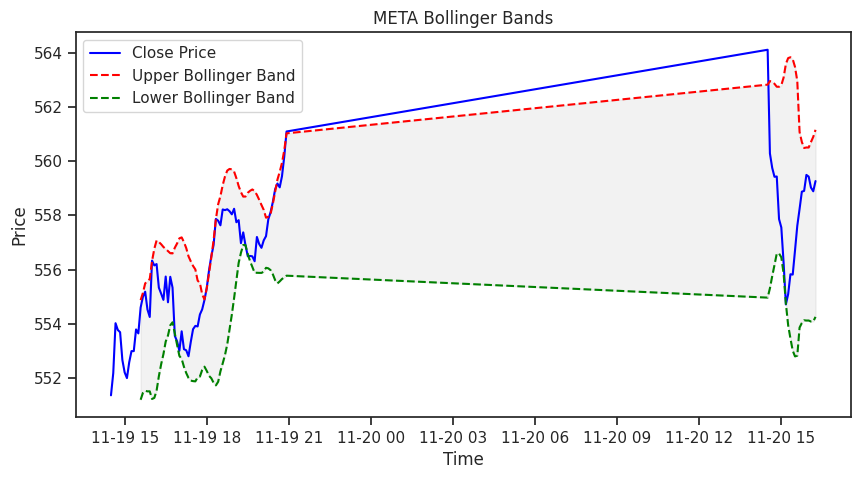

[*********************100%***********************]  1 of 1 completed


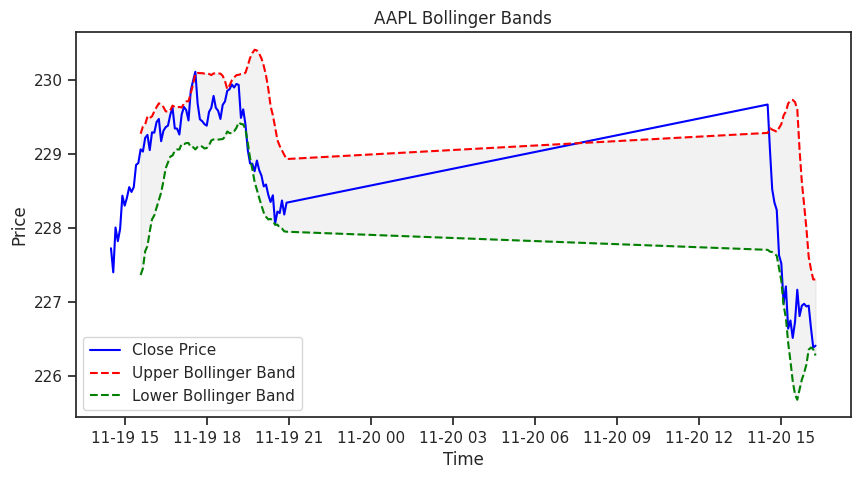

[*********************100%***********************]  1 of 1 completed


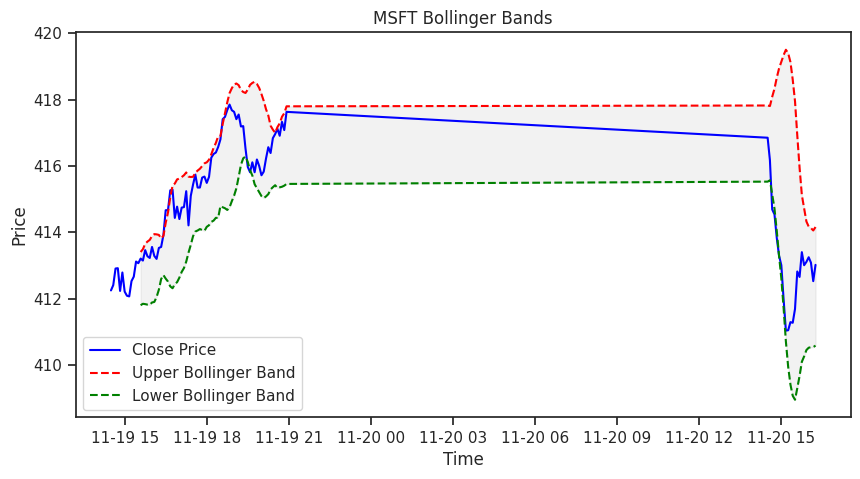

[*********************100%***********************]  1 of 1 completed


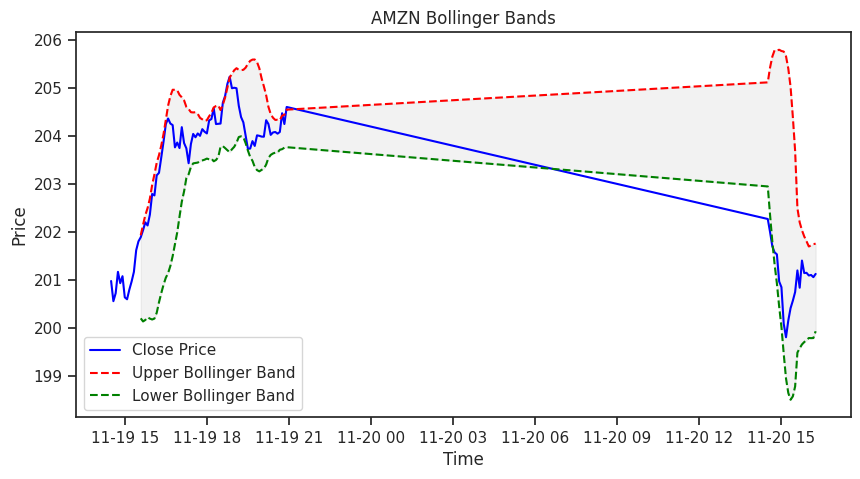

[*********************100%***********************]  1 of 1 completed


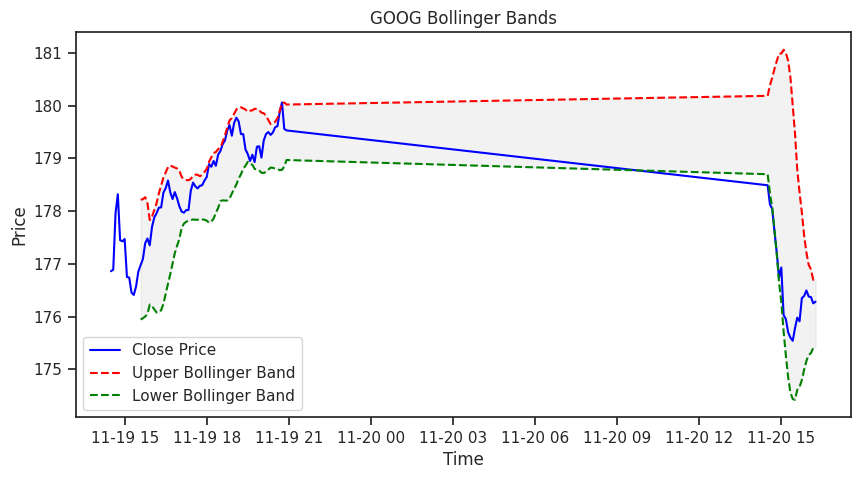

In [ ]:
ticker_data_frames = []
stats = {}
for ticker in tickers:

    # Download historical data for the ticker
    data = yf.download(ticker, period="1mo", interval="5m")

    # Calculate the daily percentage change
    close = data['Close']
    upper, lower = calculate_bollinger_bands(close, window=14, num_of_std=2)
    width = upper - lower
    rsi = calculate_rsi(close, window=14)
    roc = calculate_roc(close, periods=14)
    volume = data['Volume']
    diff = data['Close'].diff(1)
    percent_change_close = data['Close'].pct_change() * 100

    # Create a DataFrame for the current ticker and append it to the list
    ticker_df = pd.DataFrame({
    ticker+'_close': close.squeeze(),
    ticker+'_width': width.squeeze(),
    ticker+'_rsi': rsi.squeeze(),
    ticker+'_roc': roc.squeeze(),
    ticker+'_volume': volume.squeeze(),
    ticker+'_diff': diff.squeeze(),
    ticker+'_percent_change_close': percent_change_close.squeeze(),
}, index=close.index)

    MEAN = ticker_df.mean()
    STD = ticker_df.std()

    # Keep track of mean and std
    for column in MEAN.index:
      stats[f"{column}_mean"] = MEAN[column]
      stats[f"{column}_std"] = STD[column]

    # Normalize the training features
    ticker_df = (ticker_df - MEAN) / STD

    ticker_data_frames .append(ticker_df)

    # Bollinger Bands Visualization
    plt.figure(figsize=(10, 5))

    # Ensure all variables are 1-dimensional and aligned
    close = close.squeeze()
    upper = upper.squeeze()
    lower = lower.squeeze()

    # Plot close price and Bollinger Bands
    plt.plot(close[:100].index, close[:100], label="Close Price", color='blue')
    plt.plot(close[:100].index, upper[:100], label="Upper Bollinger Band", linestyle='--', color='red')
    plt.plot(close[:100].index, lower[:100], label="Lower Bollinger Band", linestyle='--', color='green')

    # Fill the area between the bands
    plt.fill_between(close[:100].index, lower[:100], upper[:100], color='gray', alpha=0.1)

    # Add labels, title, and legend
    plt.title(f"{ticker} Bollinger Bands")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


In [ ]:
tickers_daily_means = []

for df in ticker_data_frames:
  dataframe_datetime = df.reset_index()
  # Ensure Datetime column is a datetime object
  dataframe_datetime['Datetime'] = pd.to_datetime(dataframe_datetime['Datetime'])

  # Calculate daily means
  daily_means = dataframe_datetime.groupby(dataframe_datetime['Datetime'].dt.date).mean()

  # Rename the date column for clarity
  daily_means.rename(columns={"Datetime": "Date"}, inplace=True)

  tickers_daily_means.append(daily_means)




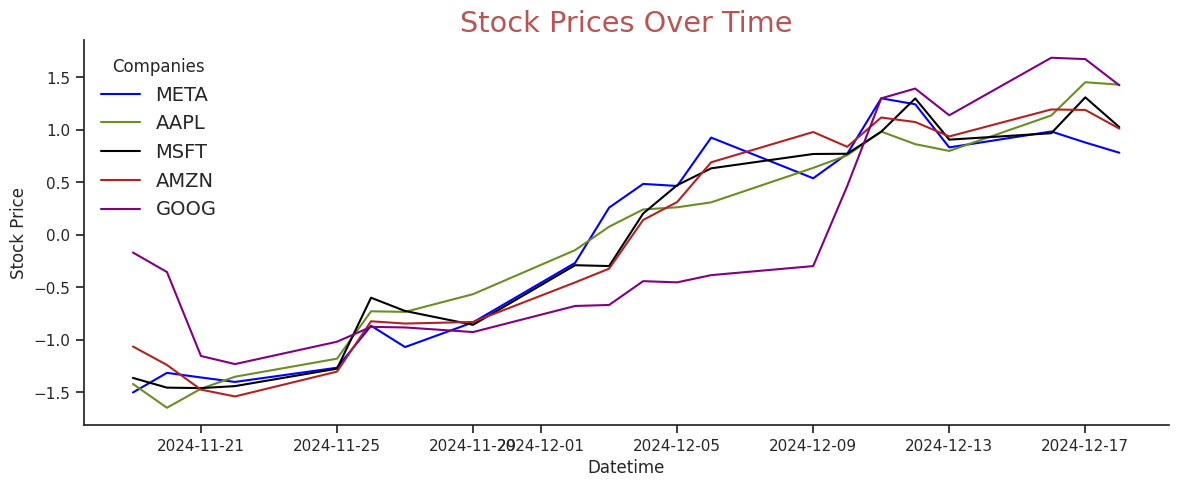

In [ ]:
# Assuming `ticker_data_frames` is a list of DataFrames for each ticker
plt.figure(figsize=(14, 5))
sns.set_style("ticks")

# Map tickers to DataFrames
company_data = dict(zip(tickers, tickers_daily_means))  # Map ticker names to DataFrames
colorr = ['blue', 'olivedrab', 'black', 'firebrick', 'purple']

# Plot data for each ticker
for ticker, clr in zip(tickers, colorr):
    data = company_data[ticker]  # Get the corresponding DataFrame
    sns.lineplot(data=data, x="Datetime", y=f"{ticker}_close", color=clr, label=ticker)

# Add chart title and labels
plt.title("Stock Prices Over Time", color="brown", alpha=0.8, size="xx-large")
plt.ylabel("Stock Price")
plt.xlabel("Datetime")

# Remove spines for a cleaner look
sns.despine()

# Add legend
plt.legend(loc="upper left", frameon=False, prop={'size': 14}, title="Companies")

# Save the figure
plt.savefig('stock_prices_over_time.png', bbox_inches='tight')
plt.show()


In [ ]:
# Convert stats from dict to df
stats = pd.DataFrame([stats], index=[0])
stats.head()

,META_close_mean,META_close_std,META_width_mean,META_width_std,META_rsi_mean,META_rsi_std,META_roc_mean,META_roc_std,META_volume_mean,META_volume_std,...,GOOG_rsi_mean,GOOG_rsi_std,GOOG_roc_mean,GOOG_roc_std,GOOG_volume_mean,GOOG_volume_std,GOOG_diff_mean,GOOG_diff_std,GOOG_percent_change_close_mean,GOOG_percent_change_close_std
0,597.563496,27.900042,5.799819,4.298264,52.24953,18.008795,0.085039,0.750908,115334.747815,124764.888653,...,51.293366,17.370041,0.076059,0.972534,211415.792135,281060.676931,0.008145,0.442332,0.004738,0.243837


In [ ]:
# Concatenate all ticker DataFrames
df = pd.concat(ticker_data_frames, axis=1)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.head()

,META_close,META_width,META_rsi,META_roc,META_volume,META_diff,META_percent_change_close,AAPL_close,AAPL_width,AAPL_rsi,...,AMZN_volume,AMZN_diff,AMZN_percent_change_close,GOOG_close,GOOG_width,GOOG_rsi,GOOG_roc,GOOG_volume,GOOG_diff,GOOG_percent_change_close
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-11-19 15:40:00+00:00,-1.525932,-0.491147,1.138928,0.763507,-0.294921,0.326658,0.353536,-1.426053,0.580573,1.237787,...,-0.379521,0.329911,0.351033,-0.294999,0.205172,0.085557,0.055519,-0.226103,0.241343,0.246828
2024-11-19 15:45:00+00:00,-1.519115,-0.428149,1.009190,0.610278,-0.222977,0.143916,0.155639,-1.403664,0.379006,1.899419,...,-0.194238,0.379551,0.403480,-0.267535,0.208155,0.252079,0.212438,-0.360761,0.660024,0.675538
2024-11-19 15:50:00+00:00,-1.542595,-0.401237,0.102719,0.008143,-0.183687,-0.610418,-0.659918,-1.398822,0.417839,1.640274,...,-0.089334,-0.191608,-0.203004,-0.259299,0.136908,-0.477574,-0.355554,-0.364931,0.185045,0.188633
2024-11-19 15:55:00+00:00,-1.552448,-0.386175,0.090622,0.002209,0.442330,-0.271134,-0.293438,-1.423632,0.203406,1.593908,...,-0.413562,0.528318,0.561192,-0.271195,-0.079578,-0.947666,-0.637536,-0.140908,-0.312287,-0.319803
2024-11-19 16:00:00+00:00,-1.477900,-0.166763,0.771799,0.522327,-0.007043,1.830315,1.982070,-1.394588,0.067727,1.637339,...,-0.341585,1.037901,1.100889,-0.239165,-0.035938,0.195468,0.067232,-0.373997,0.772826,0.789901


In [ ]:
# Shift the df data to create labels
labels = df.shift(-1)

# Drop the last row in both percent_change_data and labels as it won't have a corresponding label
df = df.iloc[:-1]
labels = labels.iloc[:-1]

In [ ]:
# Sequence len = 24 means that we have 2 hours of 5 min data
SEQUENCE_LEN = 24

# Function to create X-day sequences for each ticker
def create_sequences(data, labels, mean, std, sequence_length=SEQUENCE_LEN):
    sequences = []
    lab = []
    data_size = len(data)

    # + 12 because we want to predict the next hour
    for i in range(data_size - (sequence_length + 13)):
      if i == 0:
        continue

      sequences.append(data[i:i + sequence_length])
      lab.append([labels[i-1], labels[i + 12], mean[0], std[0]])

    for i in range(0, len(lab)):
      last_price_data = sequences[i][-1][0]
      last_price_label = lab[i][0]

      if not last_price_data == last_price_label:
        print(f"ERROR : {last_price_data=} and {last_price_label=} are not equal")

    return np.array(sequences), np.array(lab)

In [ ]:
sequences_dict = {}
sequences_labels = {}
for ticker in tickers:

    # Extract close and volume data for the ticker
    close = df[ticker+'_close'].values
    width = df[ticker+'_width'].values
    rsi = df[ticker+'_rsi'].values
    roc = df[ticker+'_roc'].values
    volume = df[ticker+'_volume'].values
    diff = df[ticker+'_diff'].values
    pct_change = df[ticker+'_percent_change_close'].values

    # Combine close and volume data
    ticker_data = np.column_stack((close,
                                   width,
                                   rsi,
                                   roc,
                                   volume,
                                   diff,
                                   pct_change))

    # Generate sequences
    attribute = ticker+"_close"
    ticker_sequences, lab = create_sequences(ticker_data,
                                             labels[attribute].values[SEQUENCE_LEN-1:],
                                             stats[attribute+"_mean"].values,
                                             stats[attribute+"_std"].values)

    sequences_dict[ticker] = ticker_sequences
    sequences_labels[ticker] = lab


print(sequences_dict["META"])
print(sequences_labels["META"])

[[[-1.51911532 -0.42814923  1.00919046 ... -0.22297738  0.14391579
    0.15563869]
  [-1.54259523 -0.40123685  0.10271856 ... -0.18368748 -0.61041835
   -0.65991759]
  [-1.55244835 -0.38617471  0.09062242 ...  0.44232999 -0.27113411
   -0.29343847]
  ...
  [-1.56858217 -0.36092303 -0.56054335 ... -0.49073701  0.39359936
    0.42701902]
  [-1.56428127 -0.38894027 -0.44842316 ... -0.55224469  0.08127703
    0.08814698]
  [-1.56499663 -0.51853295 -0.81534227 ... -0.55355115 -0.04361923
   -0.04720781]]

 [[-1.54259523 -0.40123685  0.10271856 ... -0.18368748 -0.61041835
   -0.65991759]
  [-1.55244835 -0.38617471  0.09062242 ...  0.44232999 -0.27113411
   -0.29343847]
  [-1.47790025 -0.16676297  0.77179924 ... -0.00704323  1.83031476
    1.98207016]
  ...
  [-1.56428127 -0.38894027 -0.44842316 ... -0.55224469  0.08127703
    0.08814698]
  [-1.56499663 -0.51853295 -0.81534227 ... -0.55355115 -0.04361923
   -0.04720781]
  [-1.54919752 -0.54699693 -0.3063714  ...  1.53424777  0.36756342
    0.

In [ ]:
# Combine data and labels from all tickers
all_sequences = []
all_labels = []

for ticker in tickers:
    all_sequences.extend(sequences_dict[ticker])
    all_labels.extend(sequences_labels[ticker])

# Convert to numpy arrays
all_sequences = np.array(all_sequences)
all_labels = np.array(all_labels)

In [ ]:
np.random.seed(42)
shuffled_indices = np.random.permutation(len(all_sequences))
all_sequences = all_sequences[shuffled_indices]
all_labels = all_labels[shuffled_indices]

train_size = int(len(all_sequences) * 0.9)

# Split sequences
train_sequences = all_sequences[:train_size]
train_labels    = all_labels[:train_size]

other_sequences = all_sequences[train_size:]
other_labels    = all_labels[train_size:]

shuffled_indices = np.random.permutation(len(other_sequences))
other_sequences = other_sequences[shuffled_indices]
other_labels = other_labels[shuffled_indices]

val_size = int(len(other_sequences) * 0.5)

validation_sequences = other_sequences[:val_size]
validation_labels = other_labels[:val_size]

test_sequences = other_sequences[val_size:]
test_labels = other_labels[val_size:]

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Add()([x, inputs])

    # Feed Forward Part
    y = LayerNormalization(epsilon=1e-6)(x)
    y = Dense(ff_dim, activation="relu")(y)
    y = Dropout(dropout)(y)
    y = Dense(inputs.shape[-1])(y)
    return Add()([y, x])

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs

    # Create multiple layers of the Transformer block
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    # Final part of the model
    x = GlobalAveragePooling1D()(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    outputs = Dense(1, activation="linear")(x)

    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Model parameters
input_shape = train_sequences.shape[1:]
head_size = 256
num_heads = 16
ff_dim = 1024
num_layers = 12
dropout = 0.20

# Build the model
model = build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_layers, dropout)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 24, 7)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 24, 7)          │             14 │ input_layer[0][0]      │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 24, 7)          │        126,983 │ layer_normalization[0… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 24, 7)          │              0 │ multi_head_attention[… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 24, 7)          │             14 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 24, 1024)       │          8,192 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 24, 1024)       │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 24, 7)          │          7,175 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 24, 7)          │              0 │ dense_1[0][0],         │
│                           │                        │                │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 24, 7)          │             14 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 24, 7)          │        126,983 │ layer_normalization_2… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 24, 7)          │              0 │ multi_head_attention_… │
│                           │                        │                │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 24, 7)          │             14 │ add_2[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 24, 1024)       │          8,192 │ layer_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 24, 1024)       │              0 │ dense_2[0][0]          │
├──────────────────────

 Total params: 1,708,558 (6.52 MB)

 Trainable params: 1,708,558 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def custom_mae_loss(y_true, y_pred):
    y_true_next = tf.cast(y_true[:, 1], tf.float64)
    y_pred_next = tf.cast(y_pred[:, 0], tf.float64)
    abs_error = tf.abs(y_true_next - y_pred_next)

    return tf.reduce_mean(abs_error)

def dir_acc(y_true, y_pred):
    mean, std = tf.cast(y_true[:, 2], tf.float64), tf.cast(y_true[:, 3], tf.float64)

    y_true_prev = (tf.cast(y_true[:, 0], tf.float64) * std) + mean
    y_true_next = (tf.cast(y_true[:, 1], tf.float64) * std) + mean
    y_pred_next = (tf.cast(y_pred[:, 0], tf.float64) * std) + mean

    true_change = y_true_next - y_true_prev
    pred_change = y_pred_next - y_true_prev

    correct_direction = tf.equal(tf.sign(true_change), tf.sign(pred_change))

    return tf.reduce_mean(tf.cast(correct_direction, tf.float64))

In [ ]:
2 hours  -> 1 hour price direction

2hour / 5 min => 24 window ==> after 12 steps

In [ ]:
# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss=custom_mae_loss, metrics=[dir_acc])

In [ ]:
# Define a callback to save the best model
checkpoint_callback_train = ModelCheckpoint(
    "transformer_train_model.keras",  # Filepath to save the best model
    monitor="dir_acc",  #"loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

# Define a callback to save the best model
checkpoint_callback_val = ModelCheckpoint(
    "transformer_val_model.keras",  # Filepath to save the best model
    monitor="val_dir_acc", #"val_loss",  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode="max",  # Minimize the monitored metric
    verbose=1,  # Display progress
)

def get_lr_callback(batch_size=16, mode='cos', epochs=500, plot=True):
    lr_start, lr_max, lr_min = 0.0001, 0.005, 0.00001  # Adjust learning rate boundaries
    lr_ramp_ep = int(0.30 * epochs)  # 30% of epochs for warm-up
    lr_sus_ep = max(0, int(0.10 * epochs) - lr_ramp_ep)  # Optional sustain phase, adjust as needed

    def lrfn(epoch):
        if epoch < lr_ramp_ep:  # Warm-up phase
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:  # Sustain phase at max learning rate
            lr = lr_max
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        else:
            lr = lr_min  # Default to minimum learning rate if mode is not recognized

        return lr

    if plot:  # Plot learning rate curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
model.fit(train_sequences, train_labels,
          validation_data=(validation_sequences, validation_labels),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          callbacks=[checkpoint_callback_train, checkpoint_callback_val, get_lr_callback(batch_size=BATCH_SIZE, epochs=EPOCHS)])


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - dir_acc: 0.5383 - loss: 0.2900
Epoch 1: dir_acc improved from -inf to 0.53955, saving model to transformer_train_model.keras

Epoch 1: val_dir_acc improved from -inf to 0.53943, saving model to transformer_val_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 94s 376ms/step - dir_acc: 0.5383 - loss: 0.2894 - val_dir_acc: 0.5394 - val_loss: 0.1552 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00026333333333333336.
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - dir_acc: 0.5357 - loss: 0.1994
Epoch 2: dir_acc improved from 0.53955 to 0.54283, saving model to transformer_train_model.keras

Epoch 2: val_dir_acc improved from 0.53943 to 0.57292, saving model to transformer_val_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - dir_acc: 0.5358 - loss: 0.1994 - val_dir_acc: 0.5729 - val_loss: 0.1537 - learning_rate: 2.6333e-04

In [ ]:
# Load Weights
model.load_weights("transformer_val_model.keras")

# Make predictions
accuracy = model.evaluate(test_sequences, test_labels)[1]
print(accuracy)

# Calculate additional metrics as needed
from sklearn.metrics import r2_score

predictions = model.predict(test_sequences)
r2 = r2_score(test_labels[:, 1], predictions[:, 0])
print(f"R-squared: {r2}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - dir_acc: 0.7935 - loss: 0.0657
0.7740384340286255
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 260ms/step
R-squared: 0.9907313266822523


In [ ]:
print(f"Shape of test_labels: {test_labels.shape}")
print(f"Shape of test_labels[:, tickers.index({ticker})]: {test_labels[:, tickers.index(ticker)].shape}")
print(f"Type of stats[f'{ticker}_close_std']: {type(stats[f'{ticker}_close_std'])}")
print(f"Value of stats[f'{ticker}_close_std']: {stats[f'{ticker}_close_std']}")

Shape of test_labels: (388, 4)
Shape of test_labels[:, tickers.index(META)]: (388,)
Type of stats[f'META_close_std']: <class 'pandas.core.series.Series'>
Value of stats[f'META_close_std']: 0    27.900042
Name: META_close_std, dtype: float64


In [ ]:
# 'META', 'AAPL', 'MSFT', 'AMZN', 'GOOG'
ticker = "META"

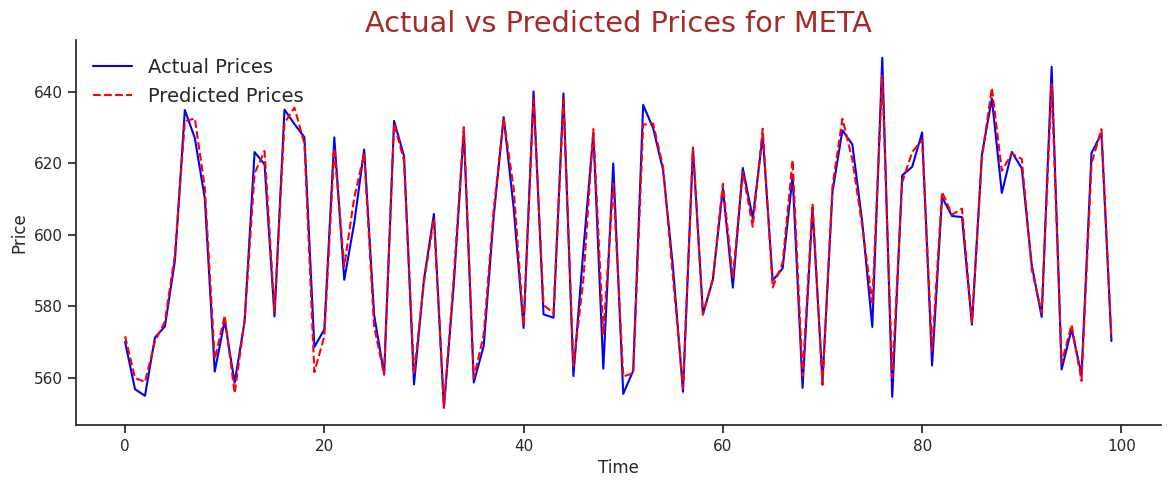

In [ ]:
# Convert stats[f"{ticker}_close_std"] and stats[f"{ticker}_close_mean"] to scalar values
ticker_std = stats[f"{ticker}_close_std"].iloc[0]  # Extract the scalar value
ticker_mean = stats[f"{ticker}_close_mean"].iloc[0]  # Extract the scalar value

# Extract true prices and predicted prices, ensuring dimensions match
true_prices = (test_labels[:, tickers.index(ticker)] * ticker_std) + ticker_mean
predicted_prices = (predictions[:, tickers.index(ticker)] * ticker_std) + ticker_mean

# Create a time range for plotting
time_range = range(len(true_prices))  # Ensure this aligns with the number of test samples

# Plot actual vs predicted prices
plt.figure(figsize=(14, 5))
sns.set_style("ticks")
plt.plot(time_range[:100], true_prices[:100], label="Actual Prices", color='blue')
plt.plot(time_range[:100], predicted_prices[:100], label="Predicted Prices", linestyle='--', color='red')

# Add labels, title, and legend
plt.title(f"Actual vs Predicted Prices for {ticker}", size="xx-large", color="brown")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="upper left", frameon=False, prop={'size': 14})
sns.despine()

plt.show()
